In [1]:
suppressPackageStartupMessages({library(dplyr)
library(Seurat)
library(readr)
library(SingleCellExperiment, quietly = TRUE)
library(scater, quietly = TRUE)
library(tidyr)
library(purrr)
library(cowplot)
library(ggrepel)
library(viridis)
library(ggdendro)
library(gridExtra)
library(egg)
library(pheatmap)})

Warning message:
"package 'Seurat' was built under R version 3.6.2"Warning message:
"package 'matrixStats' was built under R version 3.6.2"

In [2]:
setwd("/ddn1/vol1/staging/leuven/stg_00041/Adrian/AJ_0070_EPSCs_SCENIC_zygote/")

In [11]:
auc_mtx <- read.csv("/ddn1/vol1/staging/leuven/stg_00041/Adrian/AJ_0070_EPSCs_SCENIC_zygote/norm_data_run/auc_mtx_EPSC_zygote_norm_1run.csv")
colnames(auc_mtx)[2:length(colnames(auc_mtx))] <- gsub('.{0,3}$', '', colnames(auc_mtx)[2:length(colnames(auc_mtx))])
auc_mtx_matrix <- t(as.matrix(data.frame(auc_mtx[,-1], row.names = auc_mtx$Cell)))

In [3]:
load("norm_data_run/resources_folder/Figure1.Object.Robj")

In [9]:
meta_data_clean <- Figure1.Object@meta.data %>%
                                    dplyr::mutate(batch = case_when(orig.ident == "Deng" ~ "Deng",
                                                            resource == "SeuratProject" ~ "Liu",
                                                            resource == "ROSSANT" ~ "Rossant",
                                                            resource == "Elife" ~ "Elife",
                                                            resource == "Sophie" ~ "Lanner",
                                                            resource == "E3.5" | resource == "E4.5" | resource == "E5.5" | resource == "E6.75" ~ "Mohammed",
                                                            
                                                            resource == "GenomeResearch" ~ "GenomeResearch"
                                                                )) 
meta_data_clean <- data.frame(meta_data_clean, row.names = rownames(Figure1.Object@meta.data))

In [15]:
scenic_norm_seurat_int <- CreateSeuratObject(counts = auc_mtx_matrix, meta.data = meta_data_clean, min.cells = 0, min.features = 0, project = "AUC")

In [18]:
# Split object
scenic_norm_seurat_int.list <- SplitObject(scenic_norm_seurat_int, split.by = "batch")

# find variable features
for (i in 1:length(scenic_norm_seurat_int.list)) {
    scenic_norm_seurat_int.list[[i]] <- FindVariableFeatures(scenic_norm_seurat_int.list[[i]], selection.method = "vst", 
    nfeatures = 2000, verbose = FALSE)  
}
scenic_norm_seurat_int.anchors <- FindIntegrationAnchors(object.list = scenic_norm_seurat_int.list[c(2,3,6)],
                                                         dims = 1:20, 
                                                         k.filter = 200, 
                                                         verbose = F)
scenic_norm_seurat_int.integrated <- IntegrateData(anchorset = scenic_norm_seurat_int.anchors, dims = 1:20, features.to.integrate = 1:451)     

In [25]:
DefaultAssay(scenic_norm_seurat_int.integrated) <- "integrated"
scenic_norm_seurat_int.integrated <- ScaleData(scenic_norm_seurat_int.integrated, verbose = FALSE)

In [26]:
Idents(scenic_norm_seurat_int.integrated) <- "lineagez"
scenic_norm_seurat_int.integrated <- SubsetData(scenic_norm_seurat_int.integrated, ident.remove = c("E6.75", "PE","TE"))
scenic_norm_seurat_int.integrated <- ScaleData(scenic_norm_seurat_int.integrated, verbose = FALSE)
scenic_norm_seurat_int.integrated <- RunPCA(scenic_norm_seurat_int.integrated, npcs = 25, verbose = FALSE)
scenic_norm_seurat_int.integrated <- RunUMAP(scenic_norm_seurat_int.integrated, reduction = "pca", dims = 1:25, min.dist = 0.02)

Warning message:
"'SubsetData' is deprecated.
Use 'subset' instead.
See help("Deprecated")"Warning message:
"'OldWhichCells' is deprecated.
Use 'WhichCells' instead.
See help("Deprecated")"

Warning message:
"Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session."

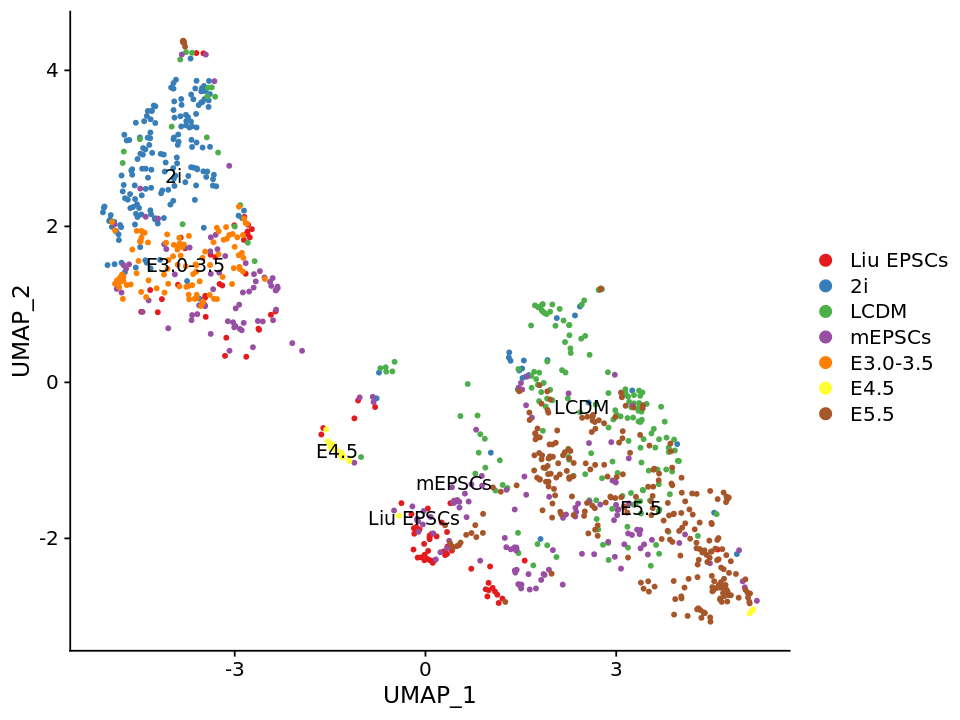

In [28]:
options(repr.plot.width=8, repr.plot.height = 6)
DimPlot(scenic_norm_seurat_int.integrated, label = TRUE) + scale_color_brewer(palette = "Set1")